In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
import polars as pl
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm import tqdm
import logging
import pyarrow as pa
import pyarrow.parquet as pq
import time
from datetime import datetime, timedelta
import sys

# QM9 and RDKit imports
from atomic_datasets import QM9
from atomic_datasets.utils.rdkit import is_molecule_sane
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator
import selfies as sf

# Import our utility functions
#from utils_qm9 import get_shape_tanimoto
import pandas as pd
#from qm9_pair_generation import is_valency_ok
import utils_mol
from utils_mol import *

# looking at moleculenet

In [84]:
100000*0.001


100.0

In [14]:
parquet_dir = '/data/lawrenh6/cache/test_new_code/qm9_pairs_per_mol_5_full' #qm9_pairs_0_001_7_18' #qm9_pairs_0_001_7_18' #qm9_pairs_test'
molecules_parquet = os.path.join(parquet_dir, 'molecules.parquet')
pairs_parquet = os.path.join(parquet_dir, 'pairs.parquet')
splits = ['train', 'val', 'test']
splits_parquet = {split: os.path.join(parquet_dir, f'pairs_{split}.parquet') for split in splits}
# # pairs_arrow = os.path.join(parquet_dir, 'pairs.arrow')

# # Read the Arrow file (IPC format)
# with pa.memory_map(pairs_parquet, "r") as source:
#     reader = ipc.RecordBatchStreamReader(source)
#     table = reader.read_all()

# Write it to Parquet
#pq.write_table(table, pairs_parquet)

molecules_df = pq.read_table(molecules_parquet).to_pandas()
pairs_df = pq.read_table(pairs_parquet).to_pandas()

split_pairs_df = {split: pq.read_table(splits_parquet[split]).to_pandas() for split in splits}

# what do the property distributions look like?

In [47]:
split_pairs_df['train'][split_pairs_df['train']['molecule_a_idx'] == 1]['molecule_b_idx']

0         0
52        0
55        6
56       46
58      157
60      653
63     3245
65    17746
68    41341
75        4
88       16
Name: molecule_b_idx, dtype: int32

In [48]:
split_pairs_df['train'][split_pairs_df['train']['molecule_b_idx'] == 1]['molecule_a_idx']

53        212
54          3
57         69
59        641
61        712
62       3154
64      17728
66      18868
67      20035
69       8753
70      10267
71       3663
72      15876
73      39535
74      97464
76      10266
77      15878
78      97424
79     115416
80        456
81       3152
82       3931
83      41257
84      97455
85      51995
86      99048
87     116143
89         27
90      13925
91      15872
92      39455
93      97439
94      60701
95      12400
96      13923
97      18742
98      39870
99      40281
100     40858
101     41304
102     45673
103     84770
Name: molecule_a_idx, dtype: int32

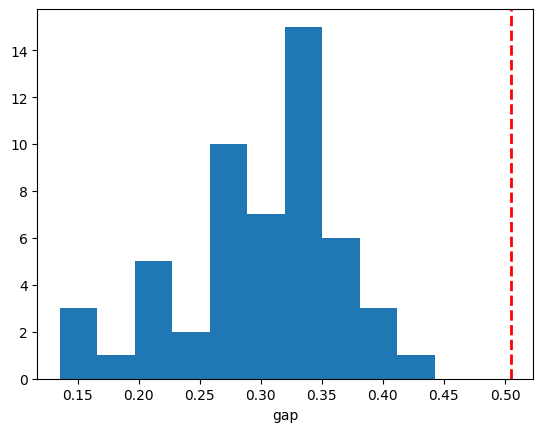

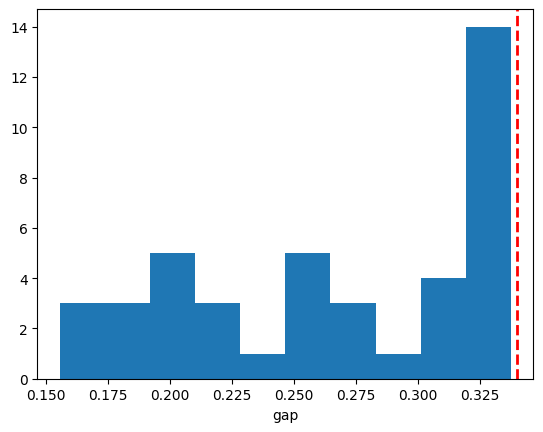

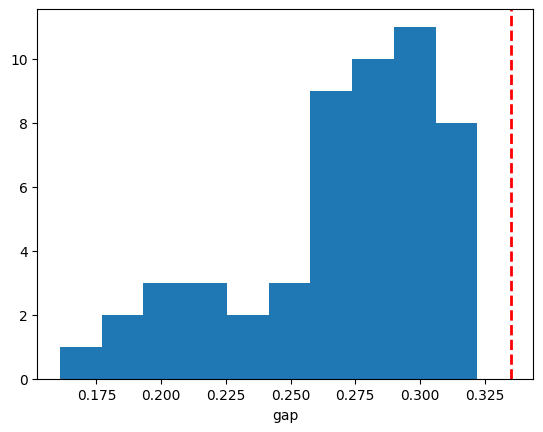

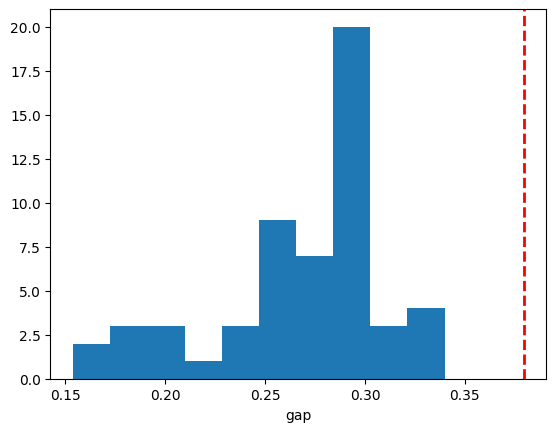

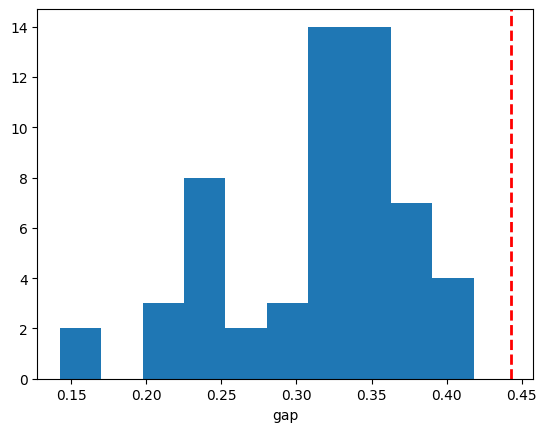

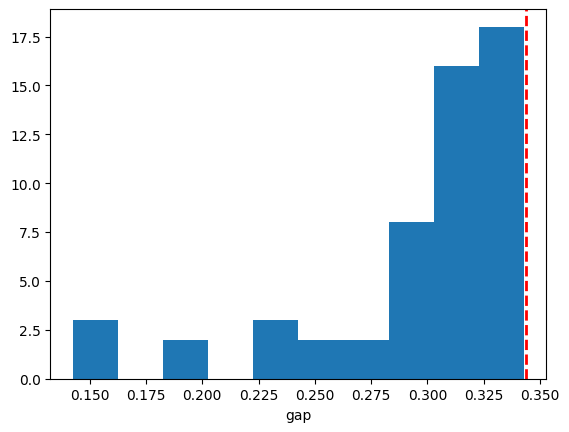

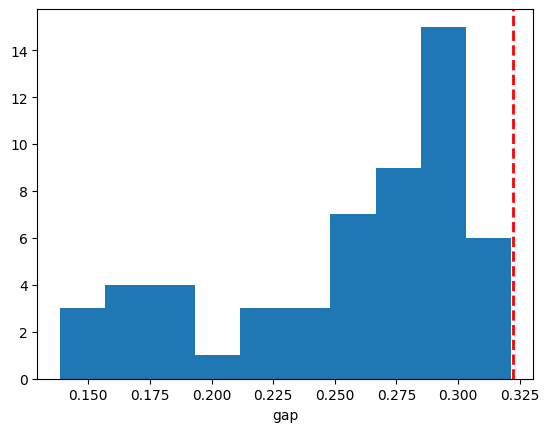

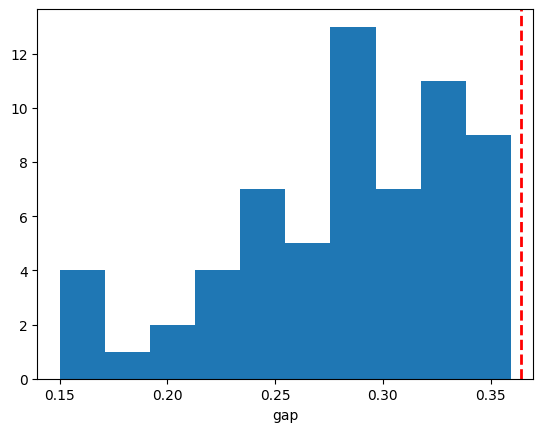

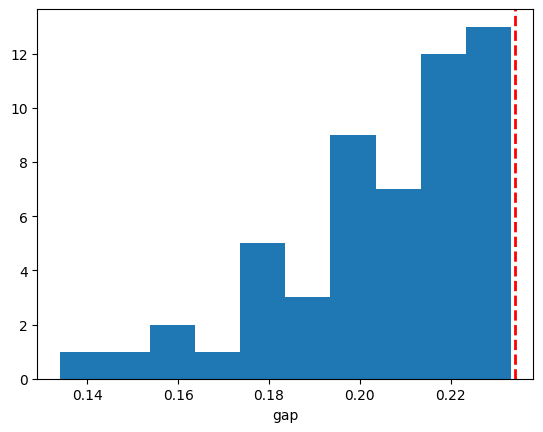

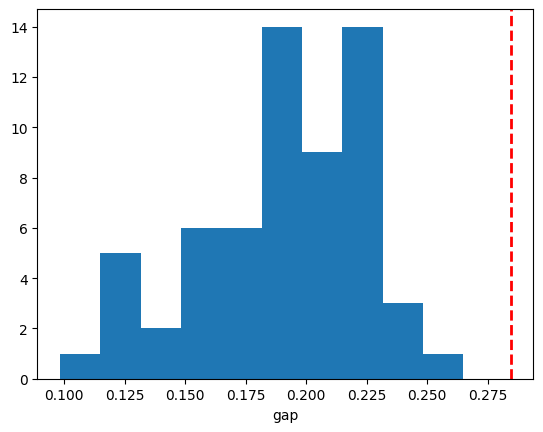

In [44]:
train_mols = list(molecules_df['item_id'][molecules_df['train'] == True])
for i in range(10):
    mol_to_check = train_mols[i]
    matches_to_mol = split_pairs_df['train'][split_pairs_df['train']['molecule_b_idx'] == mol_to_check]['molecule_a_idx']
    utility_key = 'gap'
    utility_of_mol = molecules_df.iloc[mol_to_check][utility_key]
    matched_utility_vals = molecules_df.iloc[matches_to_mol][utility_key]
    #import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(matched_utility_vals)
    plt.xlabel(utility_key)
    plt.axvline(x=utility_of_mol, color='red', linestyle='--', linewidth=2)
    plt.show()

In [26]:
len(split_pairs_df['train'][split_pairs_df['train']['molecule_b_idx'] == 4])

55

In [41]:
train_mols = list(molecules_df['item_id'][molecules_df['train'] == True])
list(train_mols)

[0,
 1,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 19,
 21,
 23,
 24,
 25,
 27,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 38,
 39,
 40,
 41,
 43,
 44,
 46,
 47,
 49,
 52,
 53,
 54,
 57,
 61,
 62,
 63,
 65,
 67,
 69,
 70,
 71,
 72,
 73,
 75,
 76,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 127,
 128,
 130,
 131,
 133,
 134,
 135,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 149,
 150,
 151,
 152,
 154,
 156,
 157,
 158,
 160,
 161,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 185,
 186,
 187,
 188,
 190,
 191,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 204,
 206,
 208,
 210,
 212,
 213,
 214,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 230,
 231,
 232,
 233,
 234,
 236,
 237,
 239,
 

In [40]:
molecules_df['item_id'][molecules_df['train'] == True]

0              0
1              1
3              3
4              4
6              6
           ...  
131739    131739
131740    131740
131741    131741
131742    131742
131743    131743
Name: item_id, Length: 105395, dtype: int64

In [15]:
molecules_df

,item_id,smiles,selfies,train,val,test,gap,homo,lumo,u0,u,h,g,cv,mu,alpha,r2,zpve
0,0,[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],True,False,False,0.5048,-0.3877,0.1171,-40.478930,0.0,0.0,0.0,6.469,0.0000,13.21,35.3641,0.044749
1,1,[H]N([H])[H],[H][N][Branch1][C][H][H],True,False,False,0.3399,-0.2570,0.0829,-56.525887,0.0,0.0,0.0,6.316,1.6256,9.46,26.1563,0.034358
2,2,[H]O[H],[H][O][H],False,False,True,0.3615,-0.2928,0.0687,-76.404702,0.0,0.0,0.0,6.002,1.8511,6.31,19.0002,0.021375
3,3,[H]C#C[H],[H][C][#C][H],True,False,False,0.3351,-0.2845,0.0506,-77.308427,0.0,0.0,0.0,8.574,0.0000,16.28,59.5248,0.026841
4,4,[H]C#N,[H][C][#N],True,False,False,0.3796,-0.3604,0.0191,-93.411888,0.0,0.0,0.0,6.278,2.8937,12.99,48.7476,0.016601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131739,131739,[H]C1([H])[C@@]23[N@H+]4[C@@]5([H])[C@]1([H])[...,[H][C][Branch1][C][H][C@@][N@H1+1][C@@][Branch...,True,False,False,0.3206,-0.2229,0.0977,-364.733608,0.0,0.0,0.0,24.820,1.4529,77.63,796.9713,0.151939
131740,131740,[H]C1([H])[C@@]2([H])[C@@]3([H])[C@@]14O[C@]1(...,[H][C][Branch1][C][H][C@@][Branch1][C][H][C@@]...,True,False,False,0.3331,-0.2427,0.0904,-384.609506,0.0,0.0,0.0,23.968,1.3774,73.24,777.3913,0.139809
131741,131741,[H]C1([H])[N@@H+]2[C@@]3([H])[C@]2([H])[C@]2([...,[H][C][Branch1][C][H][N@@H1+1][C@@][Branch1][C...,True,False,False,0.2953,-0.2233,0.0720,-380.753918,0.0,0.0,0.0,23.972,1.2480,73.60,780.3553,0.140458
131742,131742,[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14C([H])([H])...,[H][C][Branch1][C][H][N@H1+1][C@@][Branch1][C]...,True,False,False,0.3003,-0.2122,0.0881,-364.720374,0.0,0.0,0.0,24.796,1.9576,77.40,803.1904,0.152222


In [13]:
len(molecules_df)

131744

In [7]:
split_pairs_df['train']

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB
0,1,0,0.857143,0.152466,[1],[1]
1,212,0,0.857143,0.717042,"[0, 6]","[0, 1]"
2,18670,0,0.857143,0.791646,"[0, 9, 8, 10]","[0, 1, 2, 3]"
3,3,0,0.875000,0.338346,"[0, 3]","[0, 1]"
4,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]"
...,...,...,...,...,...,...
5480535,70437,131743,0.666667,0.367962,"[8, 15, 3, 2, 1, 0, 7, 4, 5, 13, 12, 14, 11, 10]","[2, 11, 1, 0, 6, 5, 7, 8, 3, 12, 15, 14, 10, 9]"
5480536,131743,106172,0.666667,0.486819,"[3, 12, 2, 11, 1, 0, 6, 5, 4, 13, 7, 8, 15, 14...","[5, 16, 8, 19, 4, 3, 2, 7, 6, 17, 1, 0, 10, 12..."
5480537,131743,106185,0.666667,0.353354,"[3, 12, 2, 11, 1, 7, 6, 5, 4, 13, 0, 10, 9, 14]","[5, 14, 8, 17, 4, 3, 2, 7, 6, 15, 1, 10, 11, 13]"
5480538,33516,131743,0.675676,0.427447,"[8, 14, 5, 11, 6, 7, 2, 3, 4, 9, 10, 1, 12]","[2, 11, 3, 12, 4, 5, 6, 0, 1, 10, 9, 7, 13]"


In [8]:
split_pairs_df['val']

,molecule_a_idx,molecule_b_idx,split,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,rmsd,matching_time
0,0,15066,val,0.483871,0.256126,"[4, 14, 13, 5, 6, 15, 16, 8, 18, 17, 1, 0, 9, ...","[5, 15, 16, 6, 8, 20, 19, 7, 17, 18, 1, 0, 9, ...",1.659078,0.024720
1,0,1729,val,0.500000,0.462630,"[6, 7, 5, 8, 18, 17, 4, 14, 13, 3, 1, 2, 11, 1...","[1, 0, 3, 2, 11, 10, 4, 13, 14, 5, 7, 6, 16, 1...",1.718522,0.007482
2,0,11411,val,0.529412,0.077453,"[6, 15, 16, 5, 4, 14, 13, 3, 1, 0, 9, 2, 11, 1...","[6, 15, 16, 5, 4, 13, 14, 3, 1, 0, 9, 2, 11, 1...",0.663744,0.037244
3,0,13770,val,0.529412,0.361274,"[6, 7, 15, 16, 5, 8, 18, 17, 1, 0, 9, 2, 3, 4,...","[7, 8, 17, 18, 6, 5, 15, 16, 1, 0, 9, 2, 3, 4,...",1.444211,0.004375
4,0,2848,val,0.531250,0.491837,"[0, 9, 1, 2, 11, 10, 3, 12, 4, 14, 13, 5, 6, 7...","[3, 13, 2, 4, 15, 14, 1, 12, 0, 10, 9, 7, 6, 5...",2.020508,0.024048
...,...,...,...,...,...,...,...,...,...
87445,17489,22,val,0.486486,0.214503,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 4, 12, 13, 7]","[6, 16, 15, 5, 14, 2, 7, 8, 17, 3, 4, 13, 12, 1]",0.379020,0.008406
87446,17489,8369,val,0.600000,0.024974,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 13, 7, 14]","[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 12, 7, 13]",0.035607,0.010965
87447,17489,12004,val,0.609756,0.433898,"[2, 9, 10, 3, 6, 7, 14, 1, 5, 4, 12, 13]","[0, 10, 9, 1, 5, 6, 16, 4, 3, 2, 12, 13]",0.943191,0.092540
87448,17489,3705,val,0.611111,0.130175,"[2, 9, 10, 3, 11, 6, 1, 0, 8, 5, 13, 7, 14]","[5, 13, 14, 6, 15, 7, 3, 4, 12, 2, 11, 8, 16]",0.079527,0.000468


In [9]:
split_pairs_df['test']

,molecule_a_idx,molecule_b_idx,split,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,rmsd,matching_time
0,17490,23849,test,0.516129,0.439583,"[0, 10, 9, 1, 13, 12, 2, 3, 4, 17, 16, 5, 8, 2...","[0, 8, 7, 1, 11, 10, 2, 3, 4, 15, 14, 5, 6, 19...",1.294384,0.001963
1,17490,24987,test,0.545455,0.477012,"[6, 19, 5, 3, 16, 2, 14, 1, 13, 0, 10, 9, 11, ...","[7, 20, 5, 3, 16, 2, 15, 1, 12, 0, 10, 9, 11, ...",1.467854,0.006763
2,17490,18432,test,0.562500,0.457944,"[6, 19, 20, 5, 3, 2, 14, 1, 13, 0, 10, 9, 11, ...","[5, 19, 18, 4, 3, 2, 13, 1, 10, 0, 8, 7, 9, 11...",1.512994,0.006078
3,17490,18707,test,0.571429,0.335540,"[0, 10, 9, 1, 13, 12, 2, 3, 4, 17, 16, 5, 8, 1...","[0, 9, 8, 1, 12, 11, 2, 3, 4, 16, 15, 5, 6, 13...",0.900471,0.001780
4,17490,21841,test,0.571429,0.295904,"[4, 17, 3, 5, 2, 14, 15, 1, 13, 0, 10, 9, 11, ...","[4, 16, 3, 5, 2, 13, 14, 1, 12, 0, 9, 8, 10, 1...",0.038527,0.004269
...,...,...,...,...,...,...,...,...,...
64370,30364,29815,test,0.500000,0.373162,"[0, 10, 9, 1, 8, 2, 13, 3, 6, 7, 18, 17, 4, 16...","[0, 10, 9, 1, 4, 8, 18, 5, 3, 2, 12, 14, 6, 16...",1.679822,0.140141
64371,30364,27888,test,0.516129,0.306255,"[0, 10, 9, 1, 2, 13, 12, 3, 6, 7, 8, 18, 5, 17...","[0, 10, 9, 1, 2, 13, 12, 3, 7, 6, 5, 17, 8, 18...",1.318957,0.092842
64372,30364,17555,test,0.552632,0.479056,"[3, 14, 4, 2, 13, 1, 7, 8, 18, 0, 10, 9, 11, 12]","[3, 12, 2, 4, 13, 5, 8, 7, 18, 6, 17, 16, 15, 14]",1.123980,0.003342
64373,30364,19862,test,0.578947,0.312285,"[0, 10, 9, 1, 2, 13, 12, 3, 4, 16, 15, 14, 7, ...","[0, 10, 9, 1, 2, 12, 13, 3, 4, 15, 16, 14, 7, ...",1.608165,0.098874


In [10]:
for split in splits:
    print(len(split_pairs_df[split]))

5480540
87450
64375


In [37]:
import torch
torch.sum(torch.tensor(molecules_df['split'] == 'test'))

tensor(99)

In [22]:
0.001*105395


105.395

In [76]:
molecules_df

,item_id,smiles,selfies,split,gap,homo,lumo,u0,u,h,g,cv,mu,alpha,r2,zpve
0,0,[H]C#CC([H])([H])[C@]1([H])O[C@]2([H])C([H])([...,[H][C][#C][C][Branch1][C][H][Branch1][C][H][C@...,train,0.2867,-0.2356,0.0511,-421.736751,0.0,0.0,0.0,33.170,2.5523,74.35,1287.7495,0.133155
1,1,[H]N([H])C(=O)C([H])([H])[C@]1([H])OC([H])([H]...,[H][N][Branch1][C][H][C][=Branch1][C][=O][C][B...,train,0.2699,-0.2359,0.0340,-401.018554,0.0,0.0,0.0,29.197,4.0777,64.93,1099.3015,0.142722
2,2,[H]OC1=C(O[H])C(=O)OC([H])=N1,[H][O][C][=C][Branch1][Ring1][O][H][C][=Branch...,train,0.1702,-0.2244,-0.0542,-509.825143,0.0,0.0,0.0,26.784,2.9557,62.09,984.2331,0.078332
3,3,[H]C1=C([H])N([H])N=C1C#CC([H])([H])[H],[H][C][=C][Branch1][C][H][N][Branch1][C][H][N]...,train,0.2222,-0.2189,0.0032,-341.586904,0.0,0.0,0.0,26.480,1.8433,76.64,1233.5156,0.108502
4,4,[H][N-][C@H]1O[C@]2([H])[C@]([H])(N([H])[H])[C...,[H][N-1][C@H1][O][C@][Branch1][C][H][C@][Branc...,train,0.2442,-0.2282,0.0160,-395.930172,0.0,0.0,0.0,28.736,1.7762,62.83,820.6823,0.119726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,289,[H]C#C[C@@]1(C([H])([H])[H])O[C@]([H])(C([H])(...,[H][C][#C][C@@][Branch1][=Branch2][C][Branch1]...,test,0.2512,-0.2448,0.0064,-385.865984,0.0,0.0,0.0,35.439,1.4796,83.92,1196.7464,0.156394
290,290,[H]O[C@]1([H])[C@](C#N)(O[H])[C@]2([H])N([H])[...,[H][O][C@][Branch1][C][H][C@][Branch1][Ring1][...,test,0.2688,-0.2609,0.0079,-453.897545,0.0,0.0,0.0,30.631,5.9102,65.34,999.4693,0.112205
291,291,[H]C1([H])OC([H])([H])C([H])([H])[C@]([H])(C([...,[H][C][Branch1][C][H][O][C][Branch1][C][H][Bra...,test,0.2254,-0.2366,-0.0111,-424.252324,0.0,0.0,0.0,33.766,1.9782,78.59,1207.7933,0.183284
292,292,[H]C1=C([H])[C@]([H])(C([H])([H])[H])[C@@]2([H...,[H][C][=C][Branch1][C][H][C@][Branch1][C][H][B...,test,0.2532,-0.2427,0.0105,-423.041224,0.0,0.0,0.0,29.462,1.2704,75.37,985.7375,0.161639


In [77]:
pairs_df[pairs_df['split']=='train']['molecule_a_idx']

0      0
1      1
2      2
3      3
4      4
      ..
92    92
93    93
94    94
95    95
96    96
Name: molecule_a_idx, Length: 97, dtype: int32

In [83]:

molecules_df.iloc[pairs_df[pairs_df['split']=='train']['molecule_b_idx']]['split']

20    train
22    train
52    train
31    train
56    train
      ...  
0     train
61    train
34    train
2     train
65    train
Name: split, Length: 97, dtype: object

In [58]:
import pathlib
print(pathlib.Path('/data/lawrenh6/cache/bbbp_try6').resolve(strict=False))

/data/lawrenh6/cache/bbbp_try6


In [57]:
import os

print("Checking directory:", os.path.dirname('/data/lawrenh6/cache/bbbp_try6/pairs.parquet'))
print("Exists?", os.path.exists('/data/lawrenh6/cache/bbbp_try6'))

Checking directory: /data/lawrenh6/cache/bbbp_try6
Exists? True


In [51]:
import pyarrow
import pyarrow.parquet as pq
import polars as pl

try:
    df = pq.read_table(pairs_parquet).to_pandas()
except Exception as e:
    print("Read failed or partial data:", e)

pairs_arrow = os.path.join(parquet_dir, 'pairs.arrow')
# pairs_df = pl.read_ipc(pairs_arrow)

def read_arrow_ipc_streaming(pairs_file_path: str):
    """
    Read Arrow IPC streaming file using record batches.
    Returns a list of all batches read so far.
    """
    batches = []
    try:
        with pa.ipc.open_stream(pairs_file_path) as reader:
            for batch in reader:
                batches.append(batch)
    except Exception as e:
        logger.debug(f"Could not read Arrow IPC stream: {e}")
        return []
    
    return batches

# Try to read the Arrow IPC streaming file
batches = read_arrow_ipc_streaming(pairs_arrow)

if batches:
    # Combine all batches into a single table
    combined_table = pa.concat_tables([pyarrow.table(batch) for batch in batches]) #pa.concat_tables(batches)
    pairs_df = pl.from_arrow(combined_table)

Read failed or partial data: /data/lawrenh6/cache/bbbp_try5/pairs.parquet


In [59]:
molecules_df

,item_id,smiles,selfies,split,SA,SC
0,0,CN(C)C[C@@H](O)[C@@H](c1ccccc1)c1ccc(Cl)cc1,[C][N][Branch1][C][C][C][C@@H1][Branch1][C][O]...,train,2.76,2.94
1,1,COc1ccc2c(C3CCN(CCCC(=O)c4ccc(F)cc4)CC3)c(C)[n...,[C][O][C][=C][C][=C][C][Branch2][Ring1][#C][C]...,train,2.29,4.18
2,2,CCOC(=O)N(CCN(C)C)c1cccc(C(F)(F)F)c1,[C][C][O][C][=Branch1][C][=O][N][Branch1][Bran...,train,2.24,3.17
3,3,CN1[C@@H]2CC[C@H]1C[C@H](OC(=O)[C@H](CO)c1cccc...,[C][N][C@@H1][C][C][C@H1][Ring1][Branch1][C][C...,train,3.94,3.20
4,4,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](...,[C][C][=Branch1][C][=O][O][C][C][=C][Branch1][...,train,3.61,3.18
...,...,...,...,...,...,...
65,5,CN(C)CCCn1c(=O)c2ccccc2c2ccccc21,[C][N][Branch1][C][C][C][C][C][N][C][=Branch1]...,test,1.81,3.32
66,6,CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,[C][N][C][C][N][Branch2][Ring2][Ring1][C][C][C...,test,2.35,4.32
67,7,COc1ccc2c(c1)N(CCCN(C)C)c1ccccc1S2,[C][O][C][=C][C][=C][C][=Branch1][Ring2][=C][R...,test,2.13,3.15
68,8,CC(C)(Oc1ccc(Cl)cc1)C(=O)N[C@@H](C(=O)N[C@@H]1...,[C][C][Branch1][C][C][Branch1][=N][O][C][=C][C...,test,3.77,3.29


In [26]:
pairs_df

molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,rmsd,matching_time
i32,i32,f32,f32,list[i32],list[i32],f32,f32
0,507,0.783784,0.807734,"[38, 9, … 44]","[11, 12, … 17]",3.172207,0.006954
0,239,0.788462,0.83618,"[31, 29, … 19]","[1, 2, … 25]",3.588046,0.041787
0,82,0.790476,0.813434,"[16, 17, … 12]","[0, 1, … 7]",2.639179,0.016939
0,81,0.794393,0.808914,"[11, 12, … 42]","[0, 1, … 25]",2.224696,0.008795
0,205,0.79798,0.748684,"[28, 27, … 29]","[0, 1, … 24]",1.875196,0.028953
…,…,…,…,…,…,…,…
159,5,0.6,0.354763,"[0, 1, … 12]","[0, 1, … 12]",0.540107,0.002466
159,97,0.710526,0.53817,"[3, 4, … 7]","[0, 1, … 9]",1.333009,0.000304
159,197,0.765957,0.650713,"[0, 1, … 7]","[8, 9, … 11]",2.069407,0.002189


(array([560.,  75.,  20.,  15.,  13.,   9.,   6.,  10.,   5.,   2.,   3.,
          0.,   0.,   0.,   2.,   0.,   2.,   1.,   0.,   1.,   6.,   0.,
          0.,   2.,   2.,   0.,   1.,   0.,   1.,   0.,   2.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   4.,
          0.,   1.,   1.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
          3.]),
 array([3.81469727e-05, 9.85640008e-03, 1.96746532e-02, 2.94929072e-02,
        3.93111594e-02, 4.91294116e-02, 5.89476675e-02, 6.87659159e-02,
        7.85841718e-02, 8.84024277e-02, 9.82206762e-02, 1.08038932e-01,
        1.17857188e-01, 1.27675444e-01, 1.37493685e-01, 1.47311941e-01,
        1.57130197e-01, 1.6694

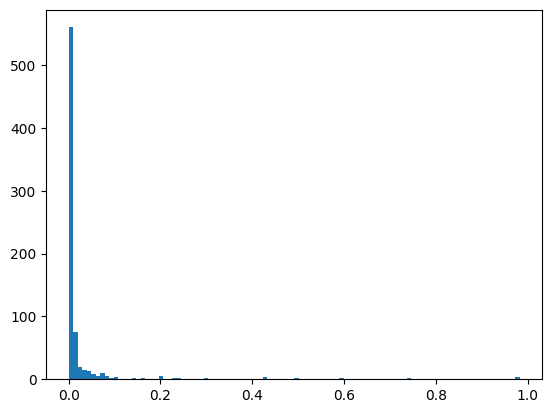

In [48]:
plt.hist(pairs_df.filter(pairs_df['matching_time']<1)['matching_time'], 100)

In [52]:
pairs_df.filter(pairs_df['molecule_a_idx'] == 0)['molecule_b_idx']

for mol_to_check in range(10):
    sub_merged = pairs_df.filter(pairs_df['molecule_a_idx'] == mol_to_check) #df_to_use[df_to_use['molecule_b_idx'] == mol_to_check]
    pair_ids = list(sub_merged['molecule_b_idx'])
    print(f'for mol {mol_to_check} got {len(pair_ids)} pairs')
    pair_morgans = sub_merged['morgan_tanimoto_distance']
    pair_shapes = sub_merged['shape_tanimoto_distance']
    pair_times = sub_merged['matching_time']
    
    print('times', list(pair_times))
    
    # first, just look at molecules without aligning
    titles = [f'{morgan:.2f} / {shape:.2f}' for (morgan, shape, time) in zip(pair_morgans, pair_shapes, pair_times)]
    mols_to_viz = [out['split_data']['molecules'][i] for i in pair_ids]
    
    titles.insert(0, 'base')
    mols_to_viz.insert(0, out['split_data']['molecules'][mol_to_check])

    visualize_mol_grid(mols=mols_to_viz, titles=titles, spacing=30, num_rows=5, num_cols=5, title_height=30);

for mol 0 got 5 pairs
times [0.0069544315338134766, 0.041786909103393555, 0.016939401626586914, 0.008794546127319336, 0.028952836990356445]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 1 got 5 pairs
times [0.009692192077636719, 0.004007577896118164, 0.004491567611694336, 0.00037360191345214844, 0.010347843170166016]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 2 got 5 pairs
times [0.010698795318603516, 0.010622978210449219, 0.010495662689208984, 0.002324342727661133, 0.01782965660095215]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 3 got 5 pairs
times [0.0002300739288330078, 0.0006411075592041016, 0.0008945465087890625, 0.0011479854583740234, 0.0014576911926269531]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 4 got 5 pairs
times [8.893013000488281e-05, 6.628036499023438e-05, 6.318092346191406e-05, 7.867813110351562e-05, 7.200241088867188e-05]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 5 got 5 pairs
times [0.0024971961975097656, 0.00608372688293457, 0.0061702728271484375, 0.01149749755859375, 0.009763717651367188]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 6 got 5 pairs
times [0.0727689266204834, 0.005864381790161133, 0.0034325122833251953, 0.01797032356262207, 0.003248929977416992]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 7 got 5 pairs
times [0.0003197193145751953, 0.0001647472381591797, 0.0002727508544921875, 0.0003116130828857422, 0.00016808509826660156]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 8 got 5 pairs
times [0.005341291427612305, 0.0017695426940917969, 0.0027000904083251953, 0.002496004104614258, 0.003421306610107422]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 9 got 5 pairs
times [0.0006048679351806641, 0.08003401756286621, 2.8262109756469727, 0.20018815994262695, 0.011977672576904297]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

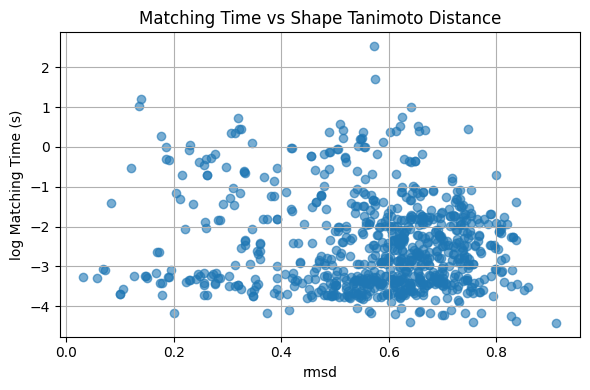

In [27]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(6, 4))
plt.scatter(pairs_df["shape_tanimoto_distance"], np.log10(pairs_df["matching_time"]), alpha=0.6)
plt.xlabel("rmsd")
plt.ylabel("log Matching Time (s)")
plt.title("Matching Time vs Shape Tanimoto Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
out['split_data']['molecules']

dict_keys(['smiles', 'selfies', 'fingerprints', 'molecules', 'dataset', 'SA', 'SC'])

In [32]:
len(out['split_data']['molecules'])

522

In [ ]:
mol_ind_to_check = 100
for mol_ind_to_check in range(3): #[0, 100, 1000, 10000]:
    mol_to_check = train_mol_inds[mol_ind_to_check]
    df_to_use = merged #filtered_merged # merged
    sub_merged = df_to_use[df_to_use['molecule_b_idx'] == mol_to_check]
    pair_ids = list(sub_merged['molecule_a_idx'])
    print(f'for mol {mol_ind_to_check} got {len(pair_ids)} pairs')
    pair_morgans = sub_merged['morgan_tanimoto_distance']
    pair_shapes = sub_merged['shape_tanimoto_distance']
    
    # first, just look at molecules without aligning
    titles = [f'{morgan:.2f} / {shape:.2f}' for (morgan, shape) in zip(pair_morgans, pair_shapes)]
    mols_to_viz = [cache['molecules'][i] for i in pair_ids]
    
    titles.insert(0, 'base')
    mols_to_viz.insert(0, cache['molecules'][mol_to_check])
    
    visualize_mol_grid(mols=mols_to_viz, titles=titles, spacing=15, num_rows=5, num_cols=5, title_height=20);
    
    # can optionally align via rmsd = rdMolAlign.AlignMol(
    #     molB, molA, prbCid=conf_id, refCid=0, atomMap=list(zip(matchB, matchA))
    # )

In [53]:
parquet_dir = '/data/lawrenh6/cache/bbbp_try6' #qm9_pairs_0_001_7_18' #qm9_pairs_test'
molecules_parquet = os.path.join(parquet_dir, 'molecules.parquet')
pairs_parquet = os.path.join(parquet_dir, 'pairs.parquet')
pairs_arrow = os.path.join(parquet_dir, 'pairs.arrow')

dset_cache = '/data/lawrenh6/cache/moleculenet_ds_caches/moleculenet_preprocessed_train.pkl'
with open(dset_cache, 'rb') as f:
    out = pickle.load(f)

molecules_df = pd.read_parquet(molecules_parquet)  # engine='pyarrow' or 'fastparquet' can be specified if needed
pairs_df = pd.read_parquet(pairs_parquet)
print(molecules_df.head())
print(pairs_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/data/lawrenh6/cache/bbbp_try6/pairs.parquet'

# looking at qm9

In [51]:
# qm9_cache_file = '/data/lawrenh6/cache/qm9_preprocessed.pkl'
# with open(qm9_cache_file, "rb") as f:
#     cache = pickle.load(f)

print(cache.keys())

dict_keys(['smiles_list', 'selfies_list', 'fingerprints', 'molecules', 'properties', 'dataset'])


In [50]:
parquet_dir = '/data/lawrenh6/cache/qm9_updated_test' #qm9_pairs_0_001_7_18' #qm9_pairs_test'
molecules_parquet = os.path.join(parquet_dir, 'molecules.parquet')
pairs_parquet = os.path.join(parquet_dir, 'pairs.parquet')

qm9_cache_file = '/data/lawrenh6/cache/qm9_ds_caches/qm9_preprocessed_train.pkl'
with open(qm9_cache_file, "rb") as f:
    cache = pickle.load(f)

molecules_df = pd.read_parquet(molecules_parquet)  # engine='pyarrow' or 'fastparquet' can be specified if needed
pairs_df = pd.read_parquet(pairs_parquet)
molecules_df.head()

,item_id,smiles,selfies,split,gap,homo,lumo,u0,u,h,g,cv,mu,alpha,r2,zpve
0,0,[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,-0.3877,0.1171,-40.478930,0.0,0.0,0.0,6.469,0.0000,13.21,35.3641,0.044749
1,1,[H]N([H])[H],[H][N][Branch1][C][H][H],train,0.3399,-0.2570,0.0829,-56.525887,0.0,0.0,0.0,6.316,1.6256,9.46,26.1563,0.034358
2,2,[H]O[H],[H][O][H],train,0.3615,-0.2928,0.0687,-76.404702,0.0,0.0,0.0,6.002,1.8511,6.31,19.0002,0.021375
3,3,[H]C#C[H],[H][C][#C][H],train,0.3351,-0.2845,0.0506,-77.308427,0.0,0.0,0.0,8.574,0.0000,16.28,59.5248,0.026841
4,4,[H]C#N,[H][C][#N],train,0.3796,-0.3604,0.0191,-93.411888,0.0,0.0,0.0,6.278,2.8937,12.99,48.7476,0.016601


In [41]:
pairs_df.head()

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB
0,0,1,0.857143,0.152466,[1],[1]
1,0,2,0.857143,0.211712,[1],[1]
2,0,3,0.875000,0.338346,"[0, 1]","[0, 3]"
3,0,6,0.875000,0.617964,"[0, 1, 2, 3]","[0, 2, 3, 4]"
4,0,15,0.875000,0.528403,"[0, 1, 2]","[0, 3, 4]"


In [52]:
# First, prepare renamed versions of molecules_df for the two roles in the pair
molecules_a = molecules_df[molecules_df['split']=='train'].add_prefix("a_")
molecules_b = molecules_df[molecules_df['split']=='train'].add_prefix("b_")

# Rename the join columns to match pairs_df
molecules_a = molecules_a.rename(columns={"a_item_id": "molecule_a_idx"})
molecules_b = molecules_b.rename(columns={"b_item_id": "molecule_b_idx"})

# Now merge onto pairs_df
merged = pairs_df \
    .merge(molecules_a, on="molecule_a_idx", how="left") \
    .merge(molecules_b, on="molecule_b_idx", how="left")

merged.head()

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,a_smiles,a_selfies,a_split,a_gap,...,b_lumo,b_u0,b_u,b_h,b_g,b_cv,b_mu,b_alpha,b_r2,b_zpve
0,0,2,0.857143,0.211712,[1],[1],[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,...,0.0687,-76.404702,0.0,0.0,0.0,6.002,1.8511,6.31,19.0002,0.021375
1,0,3,0.875000,0.338346,"[0, 1]","[0, 3]",[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,...,0.0506,-77.308427,0.0,0.0,0.0,8.574,0.0000,16.28,59.5248,0.026841
2,0,6,0.875000,0.617964,"[0, 1, 2, 3]","[0, 2, 3, 4]",[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,...,0.1041,-79.764152,0.0,0.0,0.0,10.098,0.0000,23.95,109.5031,0.074542
3,0,15,0.875000,0.528403,"[0, 1, 2]","[0, 3, 4]",[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,...,0.1042,-117.824798,0.0,0.0,0.0,11.041,0.0005,30.82,155.8145,0.081231
4,0,46,0.875000,0.627568,"[0, 1, 2]","[0, 4, 5]",[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,...,0.0956,-157.115484,0.0,0.0,0.0,14.696,0.0000,41.83,268.4432,0.110511


In [53]:
for i in range(10):
    print(len(merged[merged['molecule_a_idx']==i]))

24
0
24
24
0
24
24
24
0
24


In [15]:
#train_ds = QM9(root_dir='data/lawrenh6', split='train', check_with_rdkit=True)

In [10]:
# Are all the pairs valid and sane?
# Are all the pairs amongst the training split (ignore valid and test)?
# Are the distances accurate?
# Do the two parquet file indices seem to correspond?
# do the alignments look good?

# for a larger test set: do the chosen molecules look nice and similar?
print(cache.keys())

AttributeError: 'list' object has no attribute 'keys'

In [9]:
counter=0
for mol in cache['molecules']:
    utils_qm9.is_valency_ok(mol) # why is this different?
    counter += 1
    if counter > 10000: # weird?
        break

TypeError: list indices must be integers or slices, not str

In [13]:
merged.head()

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,a_smiles,a_selfies,a_train,a_val,...,b_lumo,b_u0,b_u,b_h,b_g,b_cv,b_mu,b_alpha,b_r2,b_zpve
0,1,0,0.857143,0.152466,[1],[1],[H]N([H])[H],[H][N][Branch1][C][H][H],True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
1,212,0,0.857143,0.717042,"[0, 6]","[0, 1]",[H]c1c([H])c([H])c([H])c([H])c1[H],[H][C][=C][Branch1][C][H][C][Branch1][C][H][=C...,True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
2,18670,0,0.857143,0.791646,"[0, 9, 8, 10]","[0, 1, 2, 3]",[H]C([H])([H])[C@]12[C@]3([H])[C@@]1([H])[C@@]...,[H][C][Branch1][C][H][Branch1][C][H][C@][C@][B...,True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
3,3,0,0.875000,0.338346,"[0, 3]","[0, 1]",[H]C#C[H],[H][C][#C][H],True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
4,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]",[H]C([H])([H])C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][C][Branch...,True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749


In [45]:
# def filter_top_percentile_per_molecule(df: pd.DataFrame, percentile: float) -> pd.DataFrame:
#     """
#     For each unique molecule_a_idx, keep only the top X percentile of pairs
#     with the lowest shape_tanimoto_distance.

#     Args:
#         df: DataFrame with columns ['molecule_a_idx', 'molecule_b_idx', 'shape_tanimoto_distance', ...]
#         percentile: float in (0, 100), e.g., 5.0 for top 5% (closest pairs)

#     Returns:
#         Filtered DataFrame with only the top X percentile pairs per molecule_a_idx.
#     """
#     def filter_group(group):
#         cutoff = group['shape_tanimoto_distance'].quantile(percentile / 100.0)
#         return group[group['shape_tanimoto_distance'] <= cutoff]

#     filtered = df.groupby('molecule_a_idx', group_keys=False).apply(filter_group)
#     return filtered.reset_index(drop=True)

# Example usage:
# df = pd.read_parquet("pairs.parquet")
# filtered_df = filter_top_percentile_per_molecule(df, percentile=5.0)
# filtered_df.to_parquet("pairs_top5percentile.parquet")

filtered_pairs_df = filter_top_percentile_per_molecule(pairs_df, percentile=1)

/tmp/ipykernel_936344/3862564564.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered = df.groupby('molecule_a_idx', group_keys=False).apply(filter_group)


In [47]:
len(filtered_pairs_df)


107922

In [50]:
new_parquet = os.path.join(parquet_dir, 'pairs_filtered_107k_shape_percentile_1.parquet')

filtered_pairs_df.to_parquet(new_parquet)

In [51]:
filtered_merged = filtered_pairs_df \
    .merge(molecules_a, on="molecule_a_idx", how="left") \
    .merge(molecules_b, on="molecule_b_idx", how="left")

In [53]:
len(filtered_merged)

107922

In [48]:
len(pairs_df)

5480540

# check: from train split

In [9]:
(merged["a_train"] == True).all()

np.True_

In [10]:
(merged["b_train"] == True).all()

np.True_

# check: are the distances accurate?

In [45]:
molecules_df

,item_id,smiles,selfies,split,gap,homo,lumo,u0,u,h,g,cv,mu,alpha,r2,zpve
0,0,[H]C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][H],train,0.5048,-0.3877,0.1171,-40.478930,0.0,0.0,0.0,6.469,0.0000,13.21,35.3641,0.044749
1,1,[H]N([H])[H],[H][N][Branch1][C][H][H],train,0.3399,-0.2570,0.0829,-56.525887,0.0,0.0,0.0,6.316,1.6256,9.46,26.1563,0.034358
2,2,[H]O[H],[H][O][H],train,0.3615,-0.2928,0.0687,-76.404702,0.0,0.0,0.0,6.002,1.8511,6.31,19.0002,0.021375
3,3,[H]C#C[H],[H][C][#C][H],train,0.3351,-0.2845,0.0506,-77.308427,0.0,0.0,0.0,8.574,0.0000,16.28,59.5248,0.026841
4,4,[H]C#N,[H][C][#N],train,0.3796,-0.3604,0.0191,-93.411888,0.0,0.0,0.0,6.278,2.8937,12.99,48.7476,0.016601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,95,[H]C1([H])O[C@@]([H])(C([H])([H])[H])C1([H])[H],[H][C][Branch1][C][H][O][C@@][Branch1][C][H][B...,test,0.3325,-0.2410,0.0915,-232.331230,0.0,0.0,0.0,18.582,1.6826,45.72,407.6909,0.114590
696,96,[H]C([H])([H])C1([H])C([H])([H])OC1([H])[H],[H][C][Branch1][C][H][Branch1][C][H][C][Branch...,test,0.3233,-0.2419,0.0814,-232.325947,0.0,0.0,0.0,18.443,1.8995,45.45,414.1575,0.114694
697,97,[H]OC1([H])C([H])([H])C([H])([H])C1([H])[H],[H][O][C][Branch1][C][H][C][Branch1][C][H][Bra...,test,0.3361,-0.2560,0.0801,-232.333258,0.0,0.0,0.0,19.023,1.4604,45.55,413.9118,0.115063
698,98,[H]OC1([H])C([H])([H])OC1([H])[H],[H][O][C][Branch1][C][H][C][Branch1][C][H][Bra...,test,0.3069,-0.2465,0.0604,-268.248371,0.0,0.0,0.0,17.344,2.4158,38.58,374.4087,0.091005


# check: what do the closest points look like?

In [55]:
train_mol_inds = list(molecules_df[molecules_df['split']=='train']['item_id'])

In [47]:
visualize_mol_grid

<function utils_qm9.visualize_mol_grid(mols, titles=None, num_rows=None, num_cols=None, spacing=5.0, width=800, height=600, title_height=None)>

In [57]:
mol_ind_to_check = 100
for mol_ind_to_check in range(3): #[0, 100, 1000, 10000]:
    mol_to_check = train_mol_inds[mol_ind_to_check]
    df_to_use = merged #filtered_merged # merged
    sub_merged = df_to_use[df_to_use['molecule_b_idx'] == mol_to_check]
    pair_ids = list(sub_merged['molecule_a_idx'])
    print(f'for mol {mol_ind_to_check} got {len(pair_ids)} pairs')
    pair_morgans = sub_merged['morgan_tanimoto_distance']
    pair_shapes = sub_merged['shape_tanimoto_distance']
    
    # first, just look at molecules without aligning
    titles = [f'{morgan:.2f} / {shape:.2f}' for (morgan, shape) in zip(pair_morgans, pair_shapes)]
    mols_to_viz = [cache['molecules'][i] for i in pair_ids]
    
    titles.insert(0, 'base')
    mols_to_viz.insert(0, cache['molecules'][mol_to_check])
    
    visualize_mol_grid(mols=mols_to_viz, titles=titles, spacing=15, num_rows=5, num_cols=5, title_height=20);
    
    # can optionally align via rmsd = rdMolAlign.AlignMol(
    #     molB, molA, prbCid=conf_id, refCid=0, atomMap=list(zip(matchB, matchA))
    # )

for mol 0 got 4 pairs


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 1 got 0 pairs


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

for mol 2 got 4 pairs


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [62]:
sub_merged

,molecule_a_idx,molecule_b_idx,morgan_tanimoto_distance,shape_tanimoto_distance,matchA,matchB,a_smiles,a_selfies,a_train,a_val,...,b_lumo,b_u0,b_u,b_h,b_g,b_cv,b_mu,b_alpha,b_r2,b_zpve
0,1,0,0.857143,0.152466,[1],[1],[H]N([H])[H],[H][N][Branch1][C][H][H],True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
1,1,0,0.857143,0.152466,[1],[1],[H]N([H])[H],[H][N][Branch1][C][H][H],True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
4,4,0,0.888889,0.298246,"[0, 2]","[0, 1]",[H]C#N,[H][C][#N],True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
5,6,0,0.875000,0.617964,"[0, 2, 3, 4]","[0, 1, 2, 3]",[H]C([H])([H])C([H])([H])[H],[H][C][Branch1][C][H][Branch1][C][H][C][Branch...,True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749
33,46,0,0.875000,0.627568,"[0, 4, 5]","[0, 1, 2]",[H]C1([H])C([H])([H])C([H])([H])C1([H])[H],[H][C][Branch1][C][H][C][Branch1][C][H][Branch...,True,False,...,0.1171,-40.47893,0.0,0.0,0.0,6.469,0.0,13.21,35.3641,0.044749


In [83]:
for ii in range(15):
    print(f'ii {ii} train {molecules_df[molecules_df['item_id'] == ii]['train']} at a {np.sum(merged['molecule_a_idx']==ii)} at b {np.sum(merged['molecule_b_idx']==ii)}')

ii 0 train 0    True
Name: train, dtype: bool at a 0 at b 53
ii 1 train 1    True
Name: train, dtype: bool at a 11 at b 42
ii 2 train 2    False
Name: train, dtype: bool at a 0 at b 0
ii 3 train 3    True
Name: train, dtype: bool at a 4 at b 52
ii 4 train 4    True
Name: train, dtype: bool at a 1 at b 55
ii 5 train 5    False
Name: train, dtype: bool at a 0 at b 0
ii 6 train 6    True
Name: train, dtype: bool at a 1 at b 57
ii 7 train 7    True
Name: train, dtype: bool at a 3 at b 54
ii 8 train 8    True
Name: train, dtype: bool at a 5 at b 55
ii 9 train 9    True
Name: train, dtype: bool at a 1 at b 63
ii 10 train 10    True
Name: train, dtype: bool at a 14 at b 54
ii 11 train 11    True
Name: train, dtype: bool at a 0 at b 61
ii 12 train 12    True
Name: train, dtype: bool at a 1 at b 56
ii 13 train 13    True
Name: train, dtype: bool at a 14 at b 42
ii 14 train 14    True
Name: train, dtype: bool at a 4 at b 51


In [81]:
molecules_df[molecules_df['item_id'] == ii]['train']

9    True
Name: train, dtype: bool